In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from dataclasses import dataclass
from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image
import requests
import cv2
from itertools import combinations
from sklearn.model_selection import train_test_split
import random
from scipy.ndimage import label
from typing import Union

/home/ubuntu/new-images/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Imports for embedding models (loaded on-demand to save GPU memory)
from transformers import CLIPProcessor, CLIPModel, AutoImageProcessor, AutoModel, AutoProcessor
import open_clip

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

Loading weights: 100%|██████████| 1468/1468 [00:01<00:00, 1248.73it/s, Materializing param=vision_encoder.neck.fpn_layers.3.proj2.weight]                       


The OrderedVocab you are attempting to save contains holes for indices [1], your vocabulary could be corrupted !
The OrderedVocab you are attempting to save contains holes for indices [1], your vocabulary could be corrupted !


In [4]:
from dataclasses import dataclass

@dataclass
class Sam3Results:
    masks: np.ndarray
    boxes: np.ndarray
    scores: np.ndarray

@dataclass
class Sample:
    image: Image.Image
    samResults: Sam3Results

@dataclass
class MyImage:
    image: Image.Image
    file_name: str
    index: int
    size: int
    samResults: Union[Sam3Results, None] = None



In [5]:
def get_sam3_results(
    model: Sam3Model,
    processor: Sam3Processor,
    # List of PIL images
    my_images: list[MyImage],
    batch_size: int = 16,
) -> list[int]:

    new_samples = []
    i = 0

    while i < len(my_images):
        batch: list[MyImage] = []

        while i < len(my_images) and len(batch) < batch_size:
            batch.append(my_images[i])
            i += 1

        images = [my_image.image for my_image in batch]

        inputs = processor(images=images, text=["distinct object"] * len(images), return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            results_batch = processor.post_process_instance_segmentation(
                outputs,
                threshold=0.5,
                mask_threshold=0.4,
                target_sizes=inputs.get("original_sizes").tolist()
            )

        for my_image, results in zip(batch, results_batch):
            my_image.samResults = Sam3Results(
                    masks=results["masks"].detach().cpu().numpy(),
                    boxes=results["boxes"].detach().cpu().numpy(),
                    scores=results["scores"].detach().cpu().numpy()
                )

        # Clean up GPU memory after each batch
        del inputs, outputs, results_batch
        torch.cuda.empty_cache()

        print(f"Processed {i}/{len(my_images)} samples")

    return my_images



In [6]:

# get a list of images from a folder
def get_images_from_folder(folder_path: str) -> list[MyImage]:
    return [MyImage(Image.open(os.path.join(folder_path, f)), f, i, os.path.getsize(os.path.join(folder_path, f))) for i, f in enumerate(os.listdir(folder_path))]



authentic_images = get_images_from_folder("./train_images/authentic/")
len(authentic_images)

2377

In [7]:
authentic_images = [image for image in authentic_images if image.size < 2*10**6]
len(authentic_images)

2206

In [8]:
sam3_results = get_sam3_results(model, processor, authentic_images[:])

Processed 16/2206 samples
Processed 32/2206 samples
Processed 48/2206 samples
Processed 64/2206 samples
Processed 80/2206 samples
Processed 96/2206 samples
Processed 112/2206 samples
Processed 128/2206 samples
Processed 144/2206 samples
Processed 160/2206 samples
Processed 176/2206 samples
Processed 192/2206 samples
Processed 208/2206 samples
Processed 224/2206 samples
Processed 240/2206 samples
Processed 256/2206 samples
Processed 272/2206 samples
Processed 288/2206 samples
Processed 304/2206 samples
Processed 320/2206 samples
Processed 336/2206 samples
Processed 352/2206 samples
Processed 368/2206 samples
Processed 384/2206 samples
Processed 400/2206 samples
Processed 416/2206 samples
Processed 432/2206 samples
Processed 448/2206 samples
Processed 464/2206 samples
Processed 480/2206 samples
Processed 496/2206 samples
Processed 512/2206 samples
Processed 528/2206 samples
Processed 544/2206 samples
Processed 560/2206 samples
Processed 576/2206 samples
Processed 592/2206 samples
Process

In [9]:
example = 8
sample_image = sam3_results[example]

In [10]:
def get_candidate_masks(sample_image: MyImage):
    candidate_masks = []
    image_size = sample_image.size
    for mask in sample_image.samResults.masks:
        mask_size = np.sum(mask)
        mask_area_ratio = mask_size / image_size
        if mask_area_ratio > 0.005 and mask_area_ratio < 0.2:
            candidate_masks.append(mask)
    return candidate_masks
candidate_masks = get_candidate_masks(sample_image)
candidate_masks

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(666, 1000)),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(666, 1000)),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(666, 1000)),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(666, 1000)),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
      

In [11]:
# Copy-paste multiple objects with overlap prevention toggle (FIXED)
def copy_paste_objects(image, masks, num_copies_list, prevent_overlap=True):
    """masks: list of masks, num_copies_list: list of copy counts per object
    prevent_overlap: if True, objects won't overlap with each other
    Returns: (forged_image, list_of_masks) - one mask per object"""
    img = np.array(image)
    h, w = img.shape[:2]
    occupied = np.zeros((h, w), dtype=bool)
    result = img.copy()
    object_masks = []

    # Mark all original masks as occupied first
    if prevent_overlap:
        for mask in masks:
            occupied[mask.astype(bool)] = True

    for mask, num_copies in zip(masks, num_copies_list):
        mask_bool = mask.astype(bool)
        rows = np.any(mask_bool, axis=1)
        cols = np.any(mask_bool, axis=0)
        y_min, y_max = np.where(rows)[0][[0, -1]]
        x_min, x_max = np.where(cols)[0][[0, -1]]
        obj_h, obj_w = y_max - y_min + 1, x_max - x_min + 1

        object_crop = img[y_min:y_max+1, x_min:x_max+1]
        mask_crop = mask_bool[y_min:y_max+1, x_min:x_max+1]
        obj_mask = mask_bool.copy()

        for _ in range(num_copies):
            for _ in range(1000):
                offset_x = random.randint(0, max(1, w - obj_w))
                offset_y = random.randint(0, max(1, h - obj_h))

                paste_region = occupied[offset_y:offset_y+obj_h, offset_x:offset_x+obj_w]
                if not prevent_overlap or not np.any(paste_region[mask_crop]):
                    result[offset_y:offset_y+obj_h, offset_x:offset_x+obj_w][mask_crop] = object_crop[mask_crop]
                    obj_mask[offset_y:offset_y+obj_h, offset_x:offset_x+obj_w] = mask_crop
                    if prevent_overlap:
                        occupied[offset_y:offset_y+obj_h, offset_x:offset_x+obj_w][mask_crop] = True
                    break

        object_masks.append(obj_mask)

    return Image.fromarray(result), object_masks

In [12]:
new_image, new_mask = copy_paste_objects(sample_image.image, candidate_masks[:2], [2,1])
new_image.save("./ourtraining/duplicate_2.png")

In [13]:
variantions = [
    {
        "name": "1.1",
        "num_copies": [1]
    },
    {
        "name": "1.2",
        "num_copies": [1]
    },
    {
        "name": "1.3",
        "num_copies": [1]
    },
    {
        "name": "2.1",
        "num_copies": [2]
    },
    {
        "name": "2.2",
        "num_copies": [2]
    },
    {
        "name": "3",
        "num_copies": [3]
    },
    {
        "name": "1-1.1",
        "num_copies": [1,1]
    },
    {
        "name": "1-1.2",
        "num_copies": [1,1]
    },
    {
        "name": "1-2",
        "num_copies": [1,2]
    },
    {
        "name": "2-1",
        "num_copies": [2,1]
    },
    {
        "name": "2-2",
        "num_copies": [2,2]
    },
    {
        "name": "1-3",
        "num_copies": [1,3]
    },
    {
        "name": "2-3",
        "num_copies": [2,3]
    },
    {
        "name": "1-1-1",
        "num_copies": [1,1,1]
    },
    {
        "name": "1-1-2",
        "num_copies": [1,1,2]
    },
    {
        "name": "1-1-3",
        "num_copies": [1,1,3]
    },
    {
        "name": "1-3-3",
        "num_copies": [1,3,3]
    },
    {
        "name": "1-1-1-1",
        "num_copies": [1,1,1,1]
    },
    {
        "name": "1-1-1-2",
        "num_copies": [1,1,1,2]
    },
    {
        "name": "1-1-1-3",
        "num_copies": [1,1,1,3]
    },
]

In [15]:
for i, image in enumerate(sam3_results[993:]):
    try:
        print(f"Processing {i+1}/{len(sam3_results)}")
        candidate_masks = get_candidate_masks(image)
        if len(candidate_masks) > 0:
            for variation in variantions:
                file_name = image.file_name.split(".")[0]
                # get random masks from candidate_masks based on variation["num_copies"]
                # it should be random with replacement
                k = len(variation["num_copies"]) if len(variation["num_copies"]) <= len(candidate_masks) else len(candidate_masks)
                random_masks = random.sample(candidate_masks, k=k)
                new_image, new_mask = copy_paste_objects(image.image, random_masks, variation["num_copies"])
                new_image.save(f"./ourtraining/images/{file_name}_{variation['name']}.png")
                np.save(f"./ourtraining/masks/{file_name}_{variation['name']}.npy", new_mask)
    except Exception as e:
        print(f"Error processing {i+1}/{len(sam3_results)}: {e}")

Processing 1/2206
Processing 2/2206
Processing 3/2206
Processing 4/2206
Processing 5/2206
Processing 6/2206
Processing 7/2206
Processing 8/2206
Processing 9/2206
Processing 10/2206
Processing 11/2206
Processing 12/2206
Processing 13/2206
Error processing 13/2206: boolean index did not match indexed array along axis 0; size of axis is 1023 but size of corresponding boolean axis is 1024
Processing 14/2206
Processing 15/2206
Processing 16/2206
Processing 17/2206
Processing 18/2206
Processing 19/2206
Processing 20/2206
Processing 21/2206
Processing 22/2206
Processing 23/2206
Processing 24/2206
Processing 25/2206
Processing 26/2206
Processing 27/2206
Processing 28/2206
Processing 29/2206
Processing 30/2206
Processing 31/2206
Processing 32/2206
Processing 33/2206
Processing 34/2206
Processing 35/2206
Processing 36/2206
Processing 37/2206
Processing 38/2206
Processing 39/2206
Processing 40/2206
Processing 41/2206
Processing 42/2206
Processing 43/2206
Processing 44/2206
Processing 45/2206
Proc

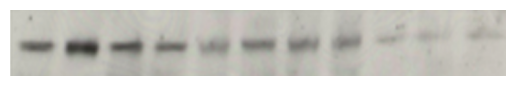

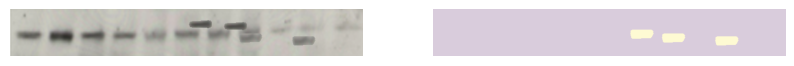

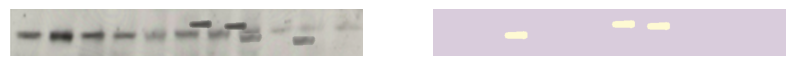

In [ ]:
import matplotlib.pyplot as plt
name  = '2430_2-2'
image = Image.open(f"./ourtraining/images/{name}.png")
authentic_image = Image.open(f"./train_images/authentic/{name.split('_')[0]}.png")
plt.imshow(authentic_image)
plt.axis('off')
plt.show()
masks = np.load(f"./ourtraining/masks/{name}.npy")

for mask in masks:
    # show the image and the mask side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(mask, alpha=0.2)
    plt.axis('off')
    plt.show()

In [16]:
from huggingface_hub import login, upload_folder

# (optional) Login with your Hugging Face credentials
login()

# Push your dataset files
upload_folder(folder_path="./ourtraining", repo_id="eliplutchok/recod_comp", repo_type="dataset")


ImportError: The `notebook_login` function can only be used in a notebook (Jupyter or Colab) and you need the `ipywidgets` module: `pip install ipywidgets`.

In [ ]:
# EASIER WAY 1: Using Hugging Face CLI (SIMPLEST - recommended!)
# For large folders, use the large folder upload command:
# huggingface-cli upload-large-folder eliplutchok/recod_comp ./ourtraining --repo-type dataset

# EASIER WAY 2: Using upload_large_folder in Python (for large datasets)
from huggingface_hub import HfApi
import os

# Login (only needed once per session)
# Option A: Use token from environment variable (recommended)
# os.environ["HF_TOKEN"] = "your_token_here"  # Get from https://huggingface.co/settings/tokens

# Option B: Use login() - may need ipywidgets: pip install ipywidgets
# from huggingface_hub import login
# login()

# Create API instance
api = HfApi()

# Upload large folder - handles large datasets better with progress tracking
api.upload_large_folder(
    folder_path="./ourtraining",
    repo_id="eliplutchok/recod_comp",
    repo_type="dataset",
    ignore_patterns=["*.ipynb_checkpoints", "__pycache__", "*.pyc"]  # Skip unnecessary files
)


Folder 'images' contains 33,057 entries (33,057 files and 0 subdirectories). This exceeds the recommended 10,000 entries per folder.
Consider reorganising into sub-folders.
Folder 'masks' contains 33,057 entries (33,057 files and 0 subdirectories). This exceeds the recommended 10,000 entries per folder.
Consider reorganising into sub-folders.
Recovering from metadata files: 100%|██████████| 66115/66115 [00:09<00:00, 6871.01it/s]





---------- 2025-12-09 14:00:19 (0:00:00) ----------
Files:   hashed 17/66115 (4.9M/55.8G) | pre-uploaded: 0/0 (0.0/55.8G) (+66115 unsure) | committed: 0/66115 (0.0/55.8G) | ignored: 0
Workers: hashing: 14 | get upload mode: 1 | pre-uploading: 0 | committing: 0 | waiting: 0
---------------------------------------------------


Processing Files (256 / 256): 100%|██████████|  123MB /  123MB, 61.4MB/s  
New Data Upload: 100%|██████████|  123MB /  123MB, 61.4MB/s  
Processing Files (256 / 256): 100%|██████████|  113MB /  113MB, 62.6MB/s  
New Data Upload: 100%|██████████|  113MB /  113MB, 62.5MB/s  
Processing Files (256 / 256): 100%|██████████|  114MB /  114MB, 51.7MB/s  
New Data Upload: 100%|██████████|  114MB /  114MB, 51.7MB/s  
Processing Files (256 / 256): 100%|██████████|  101MB /  101MB, 50.8MB/s  
New Data Upload: 100%|██████████|  101MB /  101MB, 50.6MB/s  
Processing Files (256 / 256): 100%|██████████|  105MB /  105MB, 47.8MB/s  
New Data Upload: 100%|██████████|  105MB /  105MB, 47.7MB/s  
Processing Files (256 / 256): 100%|██████████|  109MB /  109MB, 49.5MB/s  
New Data Upload: 100%|██████████|  109MB /  109MB, 49.4MB/s  
Processing Files (50 / 50): 100%|██████████| 25.6MB / 25.6MB, 25.6MB/s    
New Data Upload: |          |  0.00B /  0.00B,  0.00B/s  
Processing Files (256 / 256): 100%|██████████